<a href="https://colab.research.google.com/github/fatenchtioui/NLP/blob/main/Spark_Analyse_de_sentiment_de_pro_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse de sentiment sur des avis de produits

## Étape 1: Importer les bibliothèques nécessaires et initialiser Spark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=76475c7c000759b58a443fa2ac04d04a1a3880522dfee2f6ad7a31991288adb7
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml import Pipeline




In [ ]:
# Initialiser Spark Session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()


## Étape 2: Télécharger le jeu de données et effectuer une exploration

In [ ]:
# Charger le jeu de données à partir du fichier CSV téléchargé
file_path = "/content/training.1600000.processed.noemoticon.csv"  # Assurez-vous d'ajuster le chemin
sentiment_data_pd = pd.read_csv(file_path, header=None, names=["label", "timestamp", "text", "query", "username", "tweet"], encoding="ISO-8859-1", nrows=1000)

# Supprimer les colonnes inutiles
sentiment_data_pd = sentiment_data_pd[["label", "text"]]

# Convertir le DataFrame pandas en DataFrame Spark en spécifiant le schéma
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

schema = StructType([
    StructField("label", IntegerType(), True),
    StructField("text", StringType(), True)
])

sentiment_data_spark = spark.createDataFrame(sentiment_data_pd, schema=schema)
sentiment_data_spark.show()


+-----+--------------------+
|label|                text|
+-----+--------------------+
|    0|Mon Apr 06 22:19:...|
|    0|Mon Apr 06 22:19:...|
|    0|Mon Apr 06 22:19:...|
|    0|Mon Apr 06 22:19:...|
|    0|Mon Apr 06 22:19:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
|    0|Mon Apr 06 22:20:...|
+-----+--------------------+
only showing top 20 rows



## Étape 3: Prétraitement des données

In [ ]:
# Charger le jeu de données à partir du fichier CSV téléchargé
file_path = "/content/training.1600000.processed.noemoticon.csv"  # Assurez-vous d'ajuster le chemin
sentiment_data_pd = pd.read_csv(file_path, header=None, names=["label", "timestamp", "text", "query", "username", "tweet"], encoding="ISO-8859-1", nrows=1000)

# Supprimer les colonnes inutiles
sentiment_data_pd = sentiment_data_pd[["label", "text"]]

# Convertir le DataFrame pandas en DataFrame Spark en spécifiant le schéma
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

schema = StructType([
    StructField("label", IntegerType(), True),
    StructField("text", StringType(), True)
])

sentiment_data_spark = spark.createDataFrame(sentiment_data_pd, schema=schema)

# Tokenization et calcul de TF-IDF
tokenizer = Tokenizer(inputCol='text', outputCol='words')
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Assemblage des étapes de prétraitement en un pipeline
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
sentiment_data_spark = pipeline.fit(sentiment_data_spark).transform(sentiment_data_spark)

# Séparation des données en ensembles d'entraînement et de test
(train_data, test_data) = sentiment_data_spark.randomSplit([0.8, 0.2], seed=42)


## Étape 4: Appliquer les algorithmes de machine learning

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [ ]:

# Créer un évaluateur en spécifiant rawPredictionCol
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")

# Entraîner le modèle Logistic Regression en spécifiant la colonne rawPrediction
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lr_model = lr.fit(train_data)

# Utiliser la colonne de probabilité au lieu de rawPrediction
predictions_lr = lr_model.transform(test_data)

# Évaluer le modèle en utilisant la colonne "prediction"
auc_lr = evaluator.evaluate(predictions_lr)

# Imprimer le résultat
print(f"Logistic Regression AUC: {auc_lr}")




Logistic Regression AUC: 0.0


In [ ]:
# Créer un évaluateur en spécifiant rawPredictionCol
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")

# Gradient-Boosted Trees
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_data)

# Utiliser la colonne de probabilité au lieu de rawPrediction
predictions_gbt =gbt_model.transform(test_data)

# Évaluer le modèle en utilisant la colonne "prediction"
auc_gbt = evaluator.evaluate(predictions_gbt)

# Imprimer le résultat
print(f"Gradient-Boosted Trees AUC: {auc_gbt}")

Gradient-Boosted Trees AUC: 0.0


In [ ]:
# Créer un évaluateur en spécifiant rawPredictionCol
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")

# Forêt Aléatoire
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rf_model = rf.fit(train_data)
# Utiliser la colonne de probabilité au lieu de rawPrediction
predictions_rf =rf_model.transform(test_data)

# Évaluer le modèle en utilisant la colonne "prediction"
auc_rf = evaluator.evaluate(predictions_rf)

# Imprimer le résultat
print(f"Forêt Aléatoire AUC: {auc_rf}")

Forêt Aléatoire AUC: 0.0


## Étape 5: Visualiser les résultats

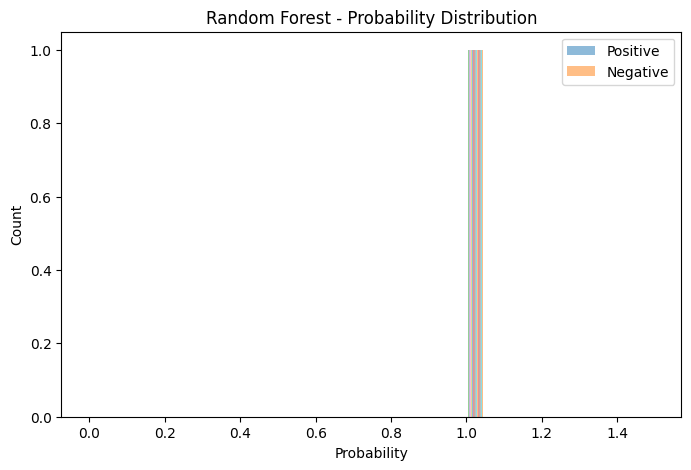

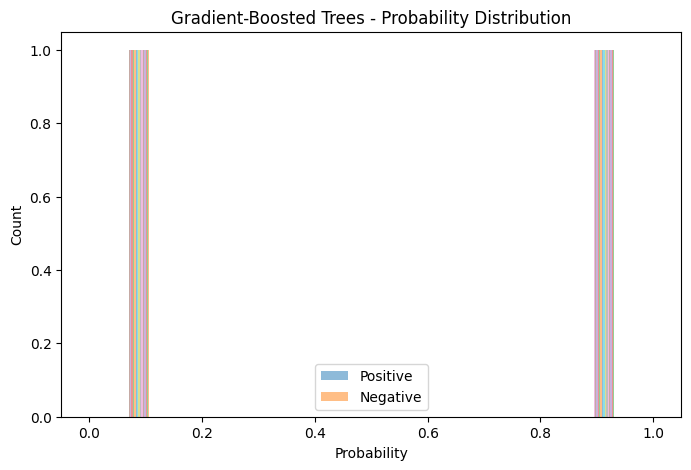

In [ ]:
# Fonction pour afficher la distribution des prédictions
def plot_distribution(predictions, model_name):
    predictions_pd = predictions.select("probability", "label").toPandas()

    plt.figure(figsize=(8, 5))
    plt.hist(predictions_pd[predictions_pd['label'] == 1]['probability'], bins=20, alpha=0.5, label='Positive')
    plt.hist(predictions_pd[predictions_pd['label'] == 0]['probability'], bins=20, alpha=0.5, label='Negative')

    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.title(f'{model_name} - Probability Distribution')
    plt.legend()
    plt.show()

# Visualiser la distribution des prédictions pour chaque modèle
plot_distribution(lr_model.transform(test_data), "Logistic Regression")
plot_distribution(rf_model.transform(test_data), "Random Forest")
plot_distribution(gbt_model.transform(test_data), "Gradient-Boosted Trees")
